In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Importing all the libraries

In [0]:
import pandas as pd
import numpy as np
import datetime as datetime
#import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,classification_report
from sklearn.utils import resample, shuffle
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
import xgboost
from datetime import datetime,date,time
import calendar

from keras import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.python.keras.metrics import Precision, Recall


Using TensorFlow backend.


Reading visit file as a pandas dataframe. The index is the row count of all the data in the visit csv file. There are a total of 178356 instances available

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MMAI896_Yorkdale/visits_full.csv',index_col='Unnamed: 0')
df.count()
# to Salman:  replace "Colab Notebooks/MMAI896_Yorkdale" with "AI", AI is the folder name you are using

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Visit_ID        1783546
DateTime        1783543
Customer_ID     1783546
Sequence_Num    1783546
Store_ID        1783546
Dwell_Time      1783546
dtype: int64

Checking for duplicate records in the file. After runing the code we find no duplicate records.

In [0]:
df[df.duplicated(subset=None,keep='first')]

,Visit_ID,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time


Now sorting the dataframe by DateTime, Customer ID and Sequence Number. This will allow us to see how a unique customer on a specfic day went about his day in a mall. Increase in sequence number for a Customer ID means that the customer went to more than one store in a day  

In [0]:
df.sort_values(by=['DateTime','Customer_ID','Sequence_Num']).head(15)

,Visit_ID,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time
1,1,2018-01-01 06:00:30,1,0,5079483,56
2,2,2018-01-01 06:00:30,1,3,5163263,201
3,3,2018-01-01 06:04:50,2,0,3,40
4,4,2018-01-01 06:46:50,3,1,5152724,10
5,5,2018-01-01 06:46:50,3,3,5079580,73
6,6,2018-01-01 07:28:20,4,2,2,168
7,7,2018-01-01 07:50:40,5,1,4,39
8,8,2018-01-01 07:56:50,6,1,3,27
9,9,2018-01-01 07:56:50,6,4,5080089,6
10,10,2018-01-01 08:28:40,7,3,2,9


The sequence number are not incrementing by 1. We know that during the data cleaning exercise any visit less than 5 minutes was removed from the dataframe. This resulted in sequence numbers not incrementing consistently. We will fix this issue by making sure that every incremental visit increments by +1 

In [0]:
df['Sequence_Num'] = df.groupby(['DateTime','Customer_ID']).cumcount() + 1

Now just exploring Customer ID 9, 10 & 11 to see if the Sequence_Num are incrementing as expected. Customer_ID 9 goes to 5 stores on 2018-01-01 and as a result Sequence number increments by + 1 until 5. At this point a new Customer_ID 10 comes in and the Sequence resets to 1. Similarly for Customer_ID 11 where he visits 2 stores. 

We were able to achieve this by grouping Customer ID and DateTime by Cumalative count. This groupby functionality increases the count by +1 for every unique Date and Customer_ID combination

In [0]:
df[(df['Customer_ID']==9) | (df['Customer_ID']==10) | (df['Customer_ID']==11)]

,Visit_ID,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time
12,12,2018-01-01 08:52:00,9,1,5079256,58
13,13,2018-01-01 08:52:00,9,2,5079256,8
14,14,2018-01-01 08:52:00,9,3,5079256,17
15,15,2018-01-01 08:52:00,9,4,3,7
16,16,2018-01-01 08:52:00,9,5,5079256,10
17,17,2018-01-01 08:58:20,10,1,5080089,7
18,18,2018-01-01 09:00:50,11,1,5080089,6
19,19,2018-01-01 09:00:50,11,2,9713461,15


Droping Visit_ID as it provides no additional explanation.


In [0]:
df = df.drop(labels=['Visit_ID'],axis=1)
df['DateTime'] = pd.to_datetime(df['DateTime'])  #Converting column DateTime which is a str to datetime 
df['Day'] = df['DateTime'].dt.weekday   # Extracting Day as a new feature from DateTime
df['Month'] = df['DateTime'].dt.month   # Extracting Month as a new feature from DateTime    

Check for any Null value and return the sum of the total value missing in each column

In [0]:
df.isnull().values.any()
df.isnull().sum()

DateTime        3
Customer_ID     0
Sequence_Num    0
Store_ID        0
Dwell_Time      0
Day             3
Month           3
dtype: int64

In [0]:
df[df['Month'].isna()] # returns all the Null values in the dataset

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month
1500432,NaT,464411,1,5080126,8,NaN,NaN
1500433,NaT,464411,2,9474122,6,NaN,NaN
1500434,NaT,464411,3,9713461,7,NaN,NaN


In [0]:
df.drop(index =[1500432,1500433,1500434],axis=0,inplace=True) #Droping the Null values from the dataset

Now we will create the Target for each row. The Target label we need to predict is the next store the customer will visit. This means each subsequent row for a unique Customer_ID is the target class. We will do this by first sorting the dataframe by DateTime, Customer ID and Sequence Number. We will then create 2 new columns to track the nex sequence and next store for a unique customer

In [0]:
df = df.sort_values(by=['DateTime','Customer_ID','Sequence_Num']) #sorts the dataframe by DateTime, Customer_ID and Sequence_Num
df['Next_Sequence'] = df['Sequence_Num'].shift(-1) #Creates a new column called Next_Sequence by shifting Sequence_Num by 1
df['Target'] = df['Store_ID'].shift(-1) #Creates a new column called Next_Store by shifting Store_ID column by 1
df.drop(index=1783546,axis=0,inplace=True)

Now lets look at Custome_ID 9 and observe how the Next Sequence and Next Store changes as he goes from one store to the other. Now as you for row 12 Sequence number is 1 and Next_sequence is 2. Similarly for row 13 we see Sequence_Num is 2 and Next_sequence is 3 and it goes on until row 16 where Sequence_Num is 5 but the Next_sequence is 1. This indicates that the Customer has left the mall

In [0]:
df[(df['Customer_ID']==9) | (df['Customer_ID']==10) | (df['Customer_ID']==11)]

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month,Next_Sequence,Target
12,2018-01-01 08:52:00,9,1,5079256,58,0.0,1.0,2.0,5079256.0
13,2018-01-01 08:52:00,9,2,5079256,8,0.0,1.0,3.0,5079256.0
14,2018-01-01 08:52:00,9,3,5079256,17,0.0,1.0,4.0,3.0
15,2018-01-01 08:52:00,9,4,3,7,0.0,1.0,5.0,5079256.0
16,2018-01-01 08:52:00,9,5,5079256,10,0.0,1.0,1.0,5080089.0
17,2018-01-01 08:58:20,10,1,5080089,7,0.0,1.0,1.0,5080089.0
18,2018-01-01 09:00:50,11,1,5080089,6,0.0,1.0,2.0,9713461.0
19,2018-01-01 09:00:50,11,2,9713461,15,0.0,1.0,1.0,3.0


The following code will put a 0 in the Target column as the customer leaves the store. I can do this by checking if the Sequence_Num is greater than Nex_Store. If i find such a record that means that the customer has exited the store.

In [0]:
df['Target']=df['Target'].astype(int)  # Converting float to integer
df['Target']= np.where(df['Sequence_Num']>=df['Next_Sequence'],0,df['Target']) 

Now just looking at the same scenrio again. We see that in row 16. Target has been changed to 0 indicating customer leaving the store at that point. Customer 10 only goes to one store and therefore he has only one instance with the Target as zero. Customer 11 goes to 2 stores.

In [0]:
df[(df['Customer_ID']==9) | (df['Customer_ID']==10) | (df['Customer_ID']==11)]

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month,Next_Sequence,Target
12,2018-01-01 08:52:00,9,1,5079256,58,0.0,1.0,2.0,5079256
13,2018-01-01 08:52:00,9,2,5079256,8,0.0,1.0,3.0,5079256
14,2018-01-01 08:52:00,9,3,5079256,17,0.0,1.0,4.0,3
15,2018-01-01 08:52:00,9,4,3,7,0.0,1.0,5.0,5079256
16,2018-01-01 08:52:00,9,5,5079256,10,0.0,1.0,1.0,0
17,2018-01-01 08:58:20,10,1,5080089,7,0.0,1.0,1.0,0
18,2018-01-01 09:00:50,11,1,5080089,6,0.0,1.0,2.0,9713461
19,2018-01-01 09:00:50,11,2,9713461,15,0.0,1.0,1.0,0


Now removing a few outliers in the data set

1.   Removing all records where we see customers before opening hours of the mall
2.   Removing all records where we see customers after the closing hours of the mall

3.   Removing all records where the Dwell time spent in a Store is more than 3 hours



In [0]:
df['Time'] = [datetime.time(d) for d in df['DateTime']] # Create a new column called Time
df = df[df['Time'] > time(10, 0, 0)] # Remove all records less than 10AM
df = df[df['Time'] < time(21,0,0) ] # Remove all records greater than 9PM
df =  df[df['Dwell_Time'] < 180] # Remove all records where Dwell time is more than 3 hours

Now bringing in other dataset to create more features for our experiment.Now bringing in the categories for each store

In [0]:
df_cat = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MMAI896_Yorkdale/stores.csv')

The dataset has a few discrepencies. In the following example all of Holt Renfrew's stores are being tracked with the same Store_ID. There are more of such casses as seen below

In [0]:
df_cat[df_cat.duplicated(subset=['Store_ID'] , keep = False)]
df_cat.count()

Store_ID         259
Category_ID      259
Category_name    259
Name             259
Slot             255
dtype: int64

In [0]:
df_cat.drop(df_cat[df_cat.duplicated(subset=['Store_ID'] , keep='first')].index, axis=0 , inplace = True) # Removing all records where unique Store_ID has multiple instances

In [0]:
df_cat.drop(columns=['Category_name','Name','Slot'],axis=1,inplace=True) # Droping all non-numerical coloumns

Combining dataframes together. The resulting dataframe will now contain a new column that will track the category of the store

In [0]:
df = df.merge(df_cat,how='inner', on='Store_ID') # Doing an inner join on Store_ID between df and df_cat


Now lets plot the data for all the stores based on the number of times it is visited. The data distribution is highly skewed with 'Exit Store' dominating over the entire data

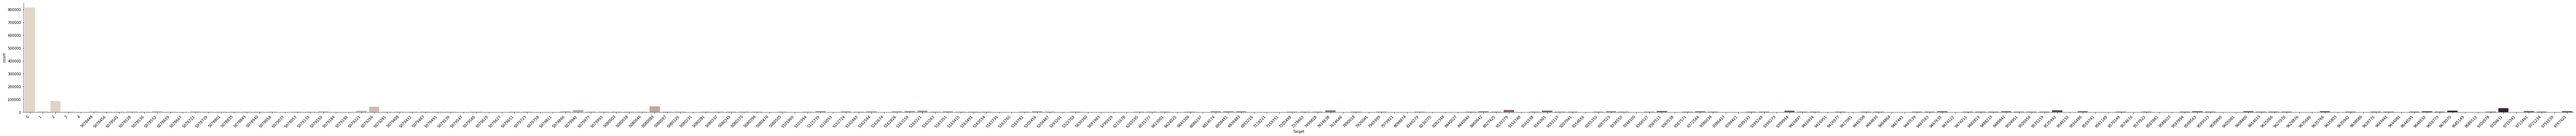

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=df,height=5, aspect=20)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

Now plotting the data without taking exit into account and arranding it by descending order to get an overall picture

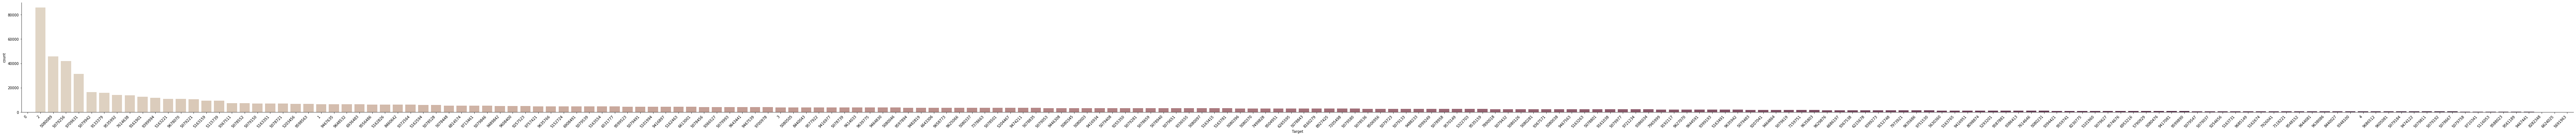

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=df[df['Target']!=0],height=5, aspect=20,order=df['Target'].value_counts().index,)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

Creating a new dataFrame which will not contain any exits from the mall

In [0]:
df_no_exit = df[df['Target']!=0]
df_no_exit.count()


DateTime         866880
Customer_ID      866880
Sequence_Num     866880
Store_ID         866880
Dwell_Time       866880
Day              866880
Month            866880
Next_Sequence    866880
Target           866880
Time             866880
Category_ID      866880
dtype: int64

In [0]:
df_no_exit_test = df_no_exit.copy()
df_no_exit_test.head(5)
# create a copy of df_no_exit - just for safety

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month,Next_Sequence,Target,Time,Category_ID
0,2018-01-01 10:03:50,26,1,9336555,35,0.0,1.0,2.0,5078501,10:03:50,14
4,2018-01-01 17:22:30,737,1,9336555,30,0.0,1.0,2.0,7614638,17:22:30,14
5,2018-01-01 17:24:10,742,2,9336555,42,0.0,1.0,3.0,5079221,17:24:10,14
6,2018-01-02 10:11:10,1377,2,9336555,33,1.0,1.0,3.0,5079256,10:11:10,14
7,2018-01-02 10:31:30,1534,2,9336555,48,1.0,1.0,3.0,9608400,10:31:30,14


In [0]:
df_no_exit_test['Target_Count'] = df_no_exit_test.groupby('Target')['Target'].transform('count')
df_no_exit_test.head(5)
# group by Target, and create a new column "Target_Count", this will help us to decide how many classes/stores to choose


,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month,Next_Sequence,Target,Time,Category_ID,Target_Count
0,2018-01-01 10:03:50,26,1,9336555,35,0.0,1.0,2.0,5078501,10:03:50,14,3490
4,2018-01-01 17:22:30,737,1,9336555,30,0.0,1.0,2.0,7614638,17:22:30,14,13925
5,2018-01-01 17:24:10,742,2,9336555,42,0.0,1.0,3.0,5079221,17:24:10,14,10670
6,2018-01-02 10:11:10,1377,2,9336555,33,1.0,1.0,3.0,5079256,10:11:10,14,41972
7,2018-01-02 10:31:30,1534,2,9336555,48,1.0,1.0,3.0,9608400,10:31:30,14,5017


In [0]:
#class_num  = {5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten',11:'eleven',12:'twelve',13:'thirteen',14:'fourteen',15:'fifteen',16:'sixteen',17:'seventeen',18:'eighteen',19:'nineteen',20:'twenty'}
class_num  = {5:'five',10:'ten',15:'fifteen',20:'twenty'}

# create dict to be used in the loop that creates different datasets contains different number of classes/stores
for i in class_num.keys():
    temp = df_no_exit_test[['Target','Target_Count']].drop_duplicates().sort_values(by=['Target_Count'], ascending = False).head(i)
    exec('{} = list(temp["Target"])'.format(class_num[i]))  
    print(temp.count())
    print(list(temp["Target"]))
# created df containing the top class_num.keys() of classes,  from 5-20, and convert the df column to list[]





Target          5
Target_Count    5
dtype: int64
[2, 5080089, 5079256, 9709631, 5079942]
Target          10
Target_Count    10
dtype: int64
[2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994]
Target          15
Target_Count    15
dtype: int64
[2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994, 5163221, 9678070, 5079221, 5163159, 5115739]
Target          20
Target_Count    20
dtype: int64
[2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994, 5163221, 9678070, 5079221, 5163159, 5115739, 9367511, 5078552, 5079150, 5163351, 5078721]


Taking the Top 5 stores by the total number of visits and bucketing the rest of the stores as 0

In [0]:

#class_num_to_list  = {5:five,6:six,7:sven,8:eight,9:nine,10:ten,11:eleven,12:twelve,13:thirteen,14:fourteen,15:fifteen,16:sixteen,17:seventeen,18:eighteen,19:nineteen,20:twenty}
# create dict to be used in the loop that creates different datasets contains different number of classes/stores, dictionary value is not a list


5
[2, 5080089, 5079256, 9709631, 5079942]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model
The distribution of train/test split is identical but there is a huge imbalance in the classes
Training a Random Forest Classfier


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


rnd_clf_wo_seq - Training set accuracy:  0.768
rnd_clf_wo_seq - Test set accuracy:  0.753
rnd_clf_wo_seq - Test set F1-Score:  0.275


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.76      0.98      0.86    129044
           2       0.53      0.12      0.20     17164
     5079256       0.00      0.00      0.00      8394
     5079942       0.71      0.49      0.58      3297
     5080089       0.00      0.00      0.00      9172
     9709631       0.44      0.01      0.01      6305

    accuracy                           0.75    173376
   macro avg       0.41      0.27      0.28    173376
weighted avg       0.65      0.75      0.67    173376

The distribution of 'other' stores is highly skewed and during training there would be a risk off overfitting on the majority class. As a result we will perform downsampling on the training data. We have wnough number of instances for us to downsample the data. We will resample without replacement and reduce the sample of overweighted class to match one of the minority class
###############################################################################

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


rnd_clf_wo_seq - downsampled - Training set accuracy:  0.549
rnd_clf_wo_seq - downsampled - Test set accuracy:  0.129
rnd_clf_wo_seq - downsampled - Test set F1-Score:  0.275
              precision    recall  f1-score   support

           0       0.91      0.00      0.01    129044
           2       0.12      0.82      0.20     17164
     5079256       0.09      0.23      0.13      8394
     5079942       0.62      0.67      0.65      3297
     5080089       0.10      0.24      0.15      9172
     9709631       0.18      0.23      0.20      6305

    accuracy                           0.13    173376
   macro avg       0.34      0.36      0.22    173376
weighted avg       0.71      0.13      0.06    173376

###################################################################################################
###################################################################################################
##################################################################################

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_no_exit_w_seq  -  Training set accuracy:  0.729
df_no_exit_w_seq  -  Test set accuracy:  0.208
df_no_exit_w_seq  -  Test set F1-Score:  0.304
              precision    recall  f1-score   support

           0       0.88      0.06      0.12    129044
           2       0.15      0.77      0.24     17164
     5079256       0.18      0.55      0.28      8394
     5079942       0.58      0.80      0.67      3297
     5080089       0.15      0.48      0.23      9172
     9709631       0.20      0.46      0.28      6305

    accuracy                           0.21    173376
   macro avg       0.36      0.52      0.30    173376
weighted avg       0.71      0.21      0.16    173376

###################################################################################################
###################################################################################################
###################################################################################################
############

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


['Day', 'Category_ID', 'Month', 0, 2, 5080089, 5079256, 9709631, 5079942, ('Dwell_Time', 0), ('Dwell_Time', 2), ('Dwell_Time', 5080089), ('Dwell_Time', 5079256), ('Dwell_Time', 9709631), ('Dwell_Time', 5079942)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:287: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_noexit - Training set accuracy:  0.809
df_extra_dwell_noexit - Test set accuracy:  0.267
df_extra_dwell_noexit - Test set F1-Score:  0.356
              precision    recall  f1-score   support

           0       0.96      0.12      0.21    797748
           2       0.16      0.82      0.27     95982
     5079256       0.21      0.75      0.33     53311
     5079942       0.56      0.87      0.68     21543
     5080089       0.18      0.66      0.28     46553
     9709631       0.26      0.62      0.37     29503

    accuracy                           0.27   1044640
   macro avg       0.39      0.64      0.36   1044640
weighted avg       0.78      0.27      0.24   1044640

###################################################################################################
###################################################################################################
###################################################################################################
###

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_two_or_more - Training set accuracy:  0.817
df_two_or_more - Test set accuracy:  0.273
df_two_or_more - Test set F1-Score:  0.358
              precision    recall  f1-score   support

           0       0.96      0.12      0.22    781048
           2       0.16      0.83      0.27     93274
     5079256       0.21      0.76      0.33     52188
     5079942       0.55      0.87      0.67     21240
     5080089       0.18      0.67      0.29     44670
     9709631       0.26      0.63      0.37     28536

    accuracy                           0.27   1020956
   macro avg       0.39      0.65      0.36   1020956
weighted avg       0.78      0.27      0.24   1020956



/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_total - Test set F1-Score:  0.484
df_extra_dwell_total - Test set Recall:  0.438
df_extra_dwell_total - Training set accuracy:  0.932
df_extra_dwell_total - Test set accuracy:  0.438
              precision    recall  f1-score   support

           0       0.99      0.29      0.45    797748
           2       0.23      0.94      0.37     95982
     5079256       0.30      0.91      0.45     53311
     5079942       0.57      1.00      0.73     21543
     5080089       0.28      0.86      0.42     46553
     9709631       0.35      0.84      0.50     29503

    accuracy                           0.44   1044640
   macro avg       0.45      0.81      0.48   1044640
weighted avg       0.83      0.44      0.45   1044640

10
[2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model
The distribution of train/test split is identical but there is a huge imbalance in the classes
Training a Random Forest Classfier


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


rnd_clf_wo_seq - Training set accuracy:  0.694
rnd_clf_wo_seq - Test set accuracy:  0.677
rnd_clf_wo_seq - Test set F1-Score:  0.163


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.68      0.98      0.80    115312
           2       0.52      0.14      0.22     17164
     5079256       0.00      0.00      0.00      8394
     5079942       0.67      0.52      0.58      3297
     5080089       0.00      0.00      0.00      9173
     7614638       0.00      0.00      0.00      2785
     9133379       0.00      0.00      0.00      3184
     9161901       0.40      0.00      0.00      2538
     9399994       0.00      0.00      0.00      2384
     9535992       0.00      0.00      0.00      2841
     9709631       0.48      0.12      0.19      6304

    accuracy                           0.68    173376
   macro avg       0.25      0.16      0.16    173376
weighted avg       0.54      0.68      0.57    173376

The distribution of 'other' stores is highly skewed and during training there would be a risk off overfitting on the majority class. As a result we will perform downsampling on the traini

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


rnd_clf_wo_seq - downsampled - Training set accuracy:  0.483
rnd_clf_wo_seq - downsampled - Test set accuracy:  0.129
rnd_clf_wo_seq - downsampled - Test set F1-Score:  0.163
              precision    recall  f1-score   support

           0       0.83      0.00      0.00    115312
           2       0.12      0.80      0.20     17164
     5079256       0.09      0.18      0.12      8394
     5079942       0.61      0.66      0.64      3297
     5080089       0.11      0.26      0.15      9173
     7614638       0.03      0.00      0.00      2785
     9133379       0.05      0.01      0.02      3184
     9161901       0.13      0.29      0.18      2538
     9399994       0.06      0.03      0.04      2384
     9535992       0.02      0.00      0.00      2841
     9709631       0.29      0.24      0.26      6304

    accuracy                           0.13    173376
   macro avg       0.21      0.23      0.15    173376
weighted avg       0.60      0.13      0.06    173376

############

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_no_exit_w_seq  -  Training set accuracy:  0.670
df_no_exit_w_seq  -  Test set accuracy:  0.191
df_no_exit_w_seq  -  Test set F1-Score:  0.242
              precision    recall  f1-score   support

           0       0.83      0.03      0.06    115312
           2       0.15      0.74      0.25     17164
     5079256       0.19      0.53      0.28      8394
     5079942       0.63      0.79      0.70      3297
     5080089       0.16      0.45      0.23      9173
     7614638       0.26      0.42      0.32      2785
     9133379       0.04      0.05      0.05      3184
     9161901       0.12      0.15      0.13      2538
     9399994       0.06      0.09      0.07      2384
     9535992       0.18      0.30      0.22      2841
     9709631       0.27      0.47      0.34      6304

    accuracy                           0.19    173376
   macro avg       0.26      0.37      0.24    173376
weighted avg       0.62      0.19      0.13    173376

##########################################

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


['Day', 'Category_ID', 'Month', 0, 2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994, ('Dwell_Time', 0), ('Dwell_Time', 2), ('Dwell_Time', 5080089), ('Dwell_Time', 5079256), ('Dwell_Time', 9709631), ('Dwell_Time', 5079942), ('Dwell_Time', 9133379), ('Dwell_Time', 9535992), ('Dwell_Time', 7614638), ('Dwell_Time', 9161901), ('Dwell_Time', 9399994)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:287: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_noexit - Training set accuracy:  0.695
df_extra_dwell_noexit - Test set accuracy:  0.243
df_extra_dwell_noexit - Test set F1-Score:  0.345
              precision    recall  f1-score   support

           0       0.97      0.05      0.10    719135
           2       0.16      0.82      0.27     95981
     5079256       0.24      0.73      0.36     53311
     5079942       0.62      0.86      0.72     21543
     5080089       0.21      0.66      0.32     46553
     7614638       0.36      0.65      0.47     16153
     9133379       0.26      0.24      0.25     17177
     9161901       0.17      0.45      0.25     10843
     9399994       0.25      0.28      0.26     18854
     9535992       0.27      0.52      0.36     15587
     9709631       0.36      0.61      0.46     29503

    accuracy                           0.24   1044640
   macro avg       0.35      0.53      0.35   1044640
weighted avg       0.75      0.24      0.17   1044640

#################################

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_two_or_more - Training set accuracy:  0.702
df_two_or_more - Test set accuracy:  0.243
df_two_or_more - Test set F1-Score:  0.346
              precision    recall  f1-score   support

           0       0.97      0.05      0.09    704671
           2       0.16      0.83      0.27     93274
     5079256       0.24      0.75      0.36     52188
     5079942       0.62      0.87      0.72     21240
     5080089       0.22      0.66      0.33     44670
     7614638       0.36      0.66      0.46     15932
     9133379       0.26      0.23      0.25     16624
     9161901       0.16      0.43      0.24     10113
     9399994       0.26      0.29      0.27     18581
     9535992       0.28      0.54      0.37     15127
     9709631       0.36      0.62      0.46     28536

    accuracy                           0.24   1020956
   macro avg       0.35      0.54      0.35   1020956
weighted avg       0.75      0.24      0.17   1020956



/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_total - Test set F1-Score:  0.504
df_extra_dwell_total - Test set Recall:  0.413
df_extra_dwell_total - Training set accuracy:  0.867
df_extra_dwell_total - Test set accuracy:  0.413
              precision    recall  f1-score   support

           0       1.00      0.21      0.34    719135
           2       0.24      0.92      0.38     95981
     5079256       0.33      0.88      0.48     53311
     5079942       0.58      1.00      0.73     21543
     5080089       0.29      0.84      0.43     46553
     7614638       0.45      0.89      0.60     16153
     9133379       0.37      0.77      0.50     17177
     9161901       0.33      0.76      0.46     10843
     9399994       0.43      0.75      0.54     18854
     9535992       0.37      0.79      0.51     15587
     9709631       0.43      0.83      0.57     29503

    accuracy                           0.41   1044640
   macro avg       0.44      0.78      0.50   1044640
weighted avg       0.79      0.41      0.39 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model
The distribution of train/test split is identical but there is a huge imbalance in the classes


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Training a Random Forest Classfier


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rnd_clf_wo_seq - Training set accuracy:  0.637
rnd_clf_wo_seq - Test set accuracy:  0.620
rnd_clf_wo_seq - Test set F1-Score:  0.115
              precision    recall  f1-score   support

           0       0.63      0.97      0.76    105073
           2       0.51      0.16      0.24     17164
     5079221       0.33      0.00      0.00      2134
     5079256       0.00      0.00      0.00      8394
     5079942       0.66      0.56      0.61      3297
     5080089       0.00      0.00      0.00      9173
     5115739       0.37      0.01      0.02      1869
     5163159       0.29      0.00      0.00      1894
     5163221       0.00      0.00      0.00      2183
     7614638       1.00      0.00      0.00      2785
     9133379       0.00      0.00      0.00      3184
     9161901       0.54      0.00      0.01      2538
     9399994       0.00      0.00      0.00      2384
     9535992       0.00      0.00      0.00      2841
     9678070       0.00      0.00      0.00      2158
  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rnd_clf_wo_seq - downsampled - Training set accuracy:  0.435
rnd_clf_wo_seq - downsampled - Test set accuracy:  0.132
rnd_clf_wo_seq - downsampled - Test set F1-Score:  0.115
              precision    recall  f1-score   support

           0       0.76      0.00      0.00    105073
           2       0.12      0.79      0.21     17164
     5079221       0.02      0.00      0.00      2134
     5079256       0.10      0.19      0.13      8394
     5079942       0.62      0.67      0.64      3297
     5080089       0.11      0.31      0.16      9173
     5115739       0.16      0.06      0.08      1869
     5163159       0.09      0.03      0.04      1894
     5163221       0.01      0.00      0.00      2183
     7614638       0.07      0.00      0.01      2785
     9133379       0.06      0.01      0.02      3184
     9161901       0.13      0.29      0.18      2538
     9399994       0.07      0.03      0.05      2384
     9535992       0.02      0.00      0.00      2841
     9678070  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


['Day', 'Month', 'Dwell_Time', 0, 2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994, 5163221, 9678070, 5079221, 5163159, 5115739]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_no_exit_w_seq  -  Training set accuracy:  0.583
df_no_exit_w_seq  -  Test set accuracy:  0.185
df_no_exit_w_seq  -  Test set F1-Score:  0.205
              precision    recall  f1-score   support

           0       0.76      0.01      0.01    105073
           2       0.14      0.78      0.24     17164
     5079221       0.16      0.11      0.13      2134
     5079256       0.21      0.55      0.30      8394
     5079942       0.67      0.80      0.73      3297
     5080089       0.19      0.47      0.27      9173
     5115739       0.07      0.03      0.04      1869
     5163159       0.04      0.02      0.03      1894
     5163221       0.11      0.07      0.09      2183
     7614638       0.30      0.42      0.35      2785
     9133379       0.07      0.04      0.05      3184
     9161901       0.18      0.15      0.16      2538
     9399994       0.13      0.08      0.10      2384
     9535992       0.22      0.31      0.26      2841
     9678070       0.14      0.11      0.12 

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


['Day', 'Category_ID', 'Month', 0, 2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994, 5163221, 9678070, 5079221, 5163159, 5115739, ('Dwell_Time', 0), ('Dwell_Time', 2), ('Dwell_Time', 5080089), ('Dwell_Time', 5079256), ('Dwell_Time', 9709631), ('Dwell_Time', 5079942), ('Dwell_Time', 9133379), ('Dwell_Time', 9535992), ('Dwell_Time', 7614638), ('Dwell_Time', 9161901), ('Dwell_Time', 9399994), ('Dwell_Time', 5163221), ('Dwell_Time', 9678070), ('Dwell_Time', 5079221), ('Dwell_Time', 5163159), ('Dwell_Time', 5115739)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:287: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_noexit - Training set accuracy:  0.616
df_extra_dwell_noexit - Test set accuracy:  0.225
df_extra_dwell_noexit - Test set F1-Score:  0.314
              precision    recall  f1-score   support

           0       0.99      0.01      0.02    657766
           2       0.16      0.82      0.27     95981
     5079221       0.37      0.32      0.35     14563
     5079256       0.24      0.73      0.36     53311
     5079942       0.60      0.86      0.71     21543
     5080089       0.20      0.67      0.31     46553
     5115739       0.34      0.16      0.22     10290
     5163159       0.31      0.15      0.20     10928
     5163221       0.30      0.26      0.28     13023
     7614638       0.36      0.66      0.46     16153
     9133379       0.31      0.18      0.23     17177
     9161901       0.18      0.43      0.25     10843
     9399994       0.37      0.24      0.29     18854
     9535992       0.29      0.49      0.36     15587
     9678070       0.35      0.22  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_two_or_more - Training set accuracy:  0.623
df_two_or_more - Test set accuracy:  0.225
df_two_or_more - Test set F1-Score:  0.316
              precision    recall  f1-score   support

           0       0.98      0.01      0.02    644643
           2       0.16      0.83      0.26     93274
     5079221       0.36      0.32      0.34     14368
     5079256       0.24      0.74      0.37     52188
     5079942       0.60      0.85      0.70     21240
     5080089       0.21      0.67      0.32     44670
     5115739       0.35      0.15      0.21     10011
     5163159       0.33      0.16      0.21     10657
     5163221       0.30      0.26      0.28     12725
     7614638       0.35      0.66      0.46     15932
     9133379       0.32      0.19      0.24     16624
     9161901       0.21      0.40      0.27     10113
     9399994       0.34      0.24      0.29     18581
     9535992       0.28      0.51      0.36     15127
     9678070       0.34      0.22      0.27     12267
  

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_total - Test set F1-Score:  0.500
df_extra_dwell_total - Test set Recall:  0.374
df_extra_dwell_total - Training set accuracy:  0.825
df_extra_dwell_total - Test set accuracy:  0.374
              precision    recall  f1-score   support

           0       1.00      0.11      0.20    657766
           2       0.24      0.90      0.39     95981
     5079221       0.45      0.82      0.58     14563
     5079256       0.33      0.86      0.48     53311
     5079942       0.55      0.99      0.71     21543
     5080089       0.28      0.82      0.42     46553
     5115739       0.58      0.50      0.54     10290
     5163159       0.55      0.55      0.55     10928
     5163221       0.35      0.78      0.48     13023
     7614638       0.45      0.87      0.60     16153
     9133379       0.36      0.73      0.48     17177
     9161901       0.36      0.70      0.48     10843
     9399994       0.42      0.73      0.53     18854
     9535992       0.37      0.77      0.50  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model
The distribution of train/test split is identical but there is a huge imbalance in the classes


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Training a Random Forest Classfier


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


rnd_clf_wo_seq - Training set accuracy:  0.600
rnd_clf_wo_seq - Test set accuracy:  0.584
rnd_clf_wo_seq - Test set F1-Score:  0.121


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.59      0.97      0.73     97808
           2       0.51      0.16      0.25     17164
     5078552       0.00      0.00      0.00      1490
     5078721       0.00      0.00      0.00      1418
     5079150       0.00      0.00      0.00      1435
     5079221       0.00      0.00      0.00      2134
     5079256       0.00      0.00      0.00      8394
     5079942       0.65      0.59      0.62      3297
     5080089       0.00      0.00      0.00      9173
     5115739       0.41      0.01      0.02      1869
     5163159       0.00      0.00      0.00      1894
     5163221       0.00      0.00      0.00      2183
     5163351       0.00      0.00      0.00      1426
     7614638       0.00      0.00      0.00      2785
     9133379       0.00      0.00      0.00      3184
     9161901       0.00      0.00      0.00      2538
     9367511       0.91      0.58      0.70      1496
     9399994       0.00    

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


rnd_clf_wo_seq - downsampled - Training set accuracy:  0.411
rnd_clf_wo_seq - downsampled - Test set accuracy:  0.136
rnd_clf_wo_seq - downsampled - Test set F1-Score:  0.121
              precision    recall  f1-score   support

           0       0.81      0.00      0.00     97808
           2       0.12      0.79      0.21     17164
     5078552       0.03      0.00      0.00      1490
     5078721       0.00      0.00      0.00      1418
     5079150       0.00      0.00      0.00      1435
     5079221       0.04      0.00      0.01      2134
     5079256       0.10      0.18      0.13      8394
     5079942       0.61      0.67      0.64      3297
     5080089       0.11      0.29      0.16      9173
     5115739       0.17      0.05      0.08      1869
     5163159       0.11      0.03      0.05      1894
     5163221       0.02      0.00      0.00      2183
     5163351       0.00      0.00      0.00      1426
     7614638       0.05      0.00      0.00      2785
     9133379  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


['Day', 'Month', 'Dwell_Time', 0, 2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994, 5163221, 9678070, 5079221, 5163159, 5115739, 9367511, 5078552, 5079150, 5163351, 5078721]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_no_exit_w_seq  -  Training set accuracy:  0.549
df_no_exit_w_seq  -  Test set accuracy:  0.197
df_no_exit_w_seq  -  Test set F1-Score:  0.237
              precision    recall  f1-score   support

           0       0.65      0.00      0.00     97808
           2       0.14      0.77      0.24     17164
     5078552       0.20      0.18      0.19      1490
     5078721       0.28      0.37      0.32      1418
     5079150       0.16      0.16      0.16      1435
     5079221       0.20      0.11      0.15      2134
     5079256       0.21      0.56      0.31      8394
     5079942       0.67      0.81      0.73      3297
     5080089       0.19      0.47      0.27      9173
     5115739       0.11      0.03      0.04      1869
     5163159       0.08      0.02      0.03      1894
     5163221       0.15      0.08      0.11      2183
     5163351       0.16      0.17      0.17      1426
     7614638       0.32      0.46      0.38      2785
     9133379       0.09      0.04      0.06 

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


['Day', 'Category_ID', 'Month', 0, 2, 5080089, 5079256, 9709631, 5079942, 9133379, 9535992, 7614638, 9161901, 9399994, 5163221, 9678070, 5079221, 5163159, 5115739, 9367511, 5078552, 5079150, 5163351, 5078721, ('Dwell_Time', 0), ('Dwell_Time', 2), ('Dwell_Time', 5080089), ('Dwell_Time', 5079256), ('Dwell_Time', 9709631), ('Dwell_Time', 5079942), ('Dwell_Time', 9133379), ('Dwell_Time', 9535992), ('Dwell_Time', 7614638), ('Dwell_Time', 9161901), ('Dwell_Time', 9399994), ('Dwell_Time', 5163221), ('Dwell_Time', 9678070), ('Dwell_Time', 5079221), ('Dwell_Time', 5163159), ('Dwell_Time', 5115739), ('Dwell_Time', 9367511), ('Dwell_Time', 5078552), ('Dwell_Time', 5079150), ('Dwell_Time', 5163351), ('Dwell_Time', 5078721)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:287: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_noexit - Training set accuracy:  0.588
df_extra_dwell_noexit - Test set accuracy:  0.241
df_extra_dwell_noexit - Test set F1-Score:  0.352
              precision    recall  f1-score   support

           0       1.00      0.01      0.01    611955
           2       0.16      0.83      0.27     95981
     5078552       0.37      0.39      0.38     10053
     5078721       0.35      0.56      0.43      9052
     5079150       0.35      0.36      0.35      8666
     5079221       0.44      0.30      0.35     14563
     5079256       0.25      0.73      0.37     53311
     5079942       0.63      0.85      0.72     21543
     5080089       0.20      0.62      0.31     46553
     5115739       0.43      0.15      0.22     10290
     5163159       0.39      0.13      0.20     10928
     5163221       0.35      0.25      0.29     13023
     5163351       0.31      0.34      0.33      8475
     7614638       0.38      0.65      0.48     16153
     9133379       0.37      0.18  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_two_or_more - Training set accuracy:  0.597
df_two_or_more - Test set accuracy:  0.244
df_two_or_more - Test set F1-Score:  0.355
              precision    recall  f1-score   support

           0       0.99      0.01      0.01    599570
           2       0.16      0.84      0.27     93274
     5078552       0.35      0.40      0.37      9868
     5078721       0.35      0.58      0.43      8945
     5079150       0.33      0.37      0.35      8494
     5079221       0.44      0.29      0.35     14367
     5079256       0.25      0.74      0.37     52188
     5079942       0.62      0.85      0.72     21240
     5080089       0.21      0.64      0.32     44670
     5115739       0.43      0.15      0.22     10011
     5163159       0.41      0.14      0.21     10657
     5163221       0.33      0.25      0.29     12725
     5163351       0.31      0.34      0.33      8325
     7614638       0.38      0.65      0.48     15932
     9133379       0.36      0.19      0.25     16624
  

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:417: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


df_extra_dwell_total - Test set F1-Score:  0.527
df_extra_dwell_total - Test set Recall:  0.392
df_extra_dwell_total - Training set accuracy:  0.816
df_extra_dwell_total - Test set accuracy:  0.392
              precision    recall  f1-score   support

           0       1.00      0.10      0.18    611955
           2       0.26      0.89      0.41     95981
     5078552       0.39      0.82      0.53     10053
     5078721       0.48      0.86      0.62      9052
     5079150       0.35      0.80      0.49      8666
     5079221       0.47      0.80      0.59     14563
     5079256       0.34      0.86      0.49     53311
     5079942       0.57      0.99      0.73     21543
     5080089       0.31      0.79      0.44     46553
     5115739       0.60      0.50      0.54     10290
     5163159       0.58      0.52      0.55     10928
     5163221       0.36      0.75      0.49     13023
     5163351       0.36      0.80      0.50      8475
     7614638       0.48      0.86      0.62  

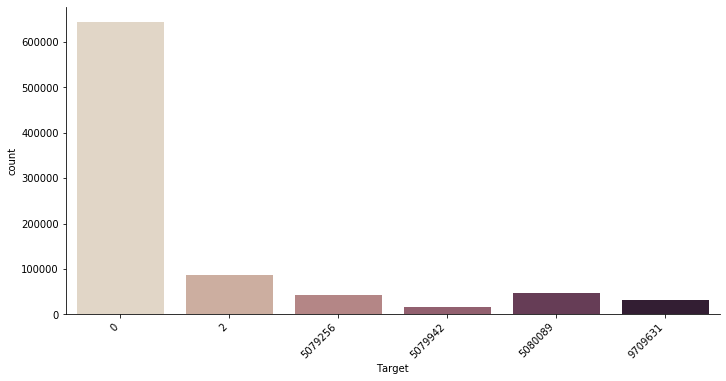

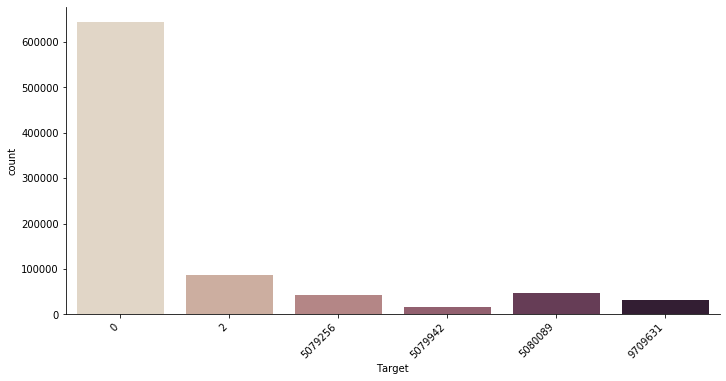

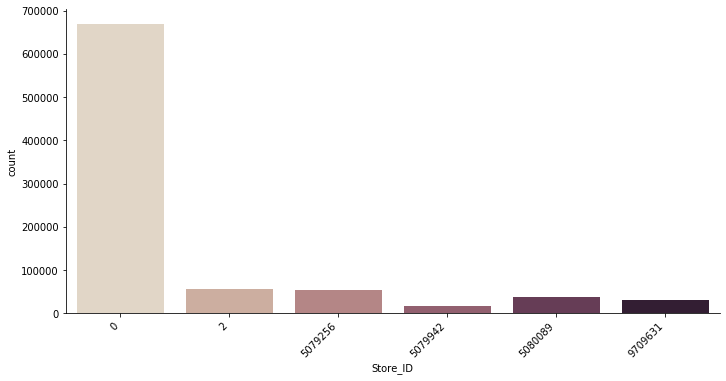

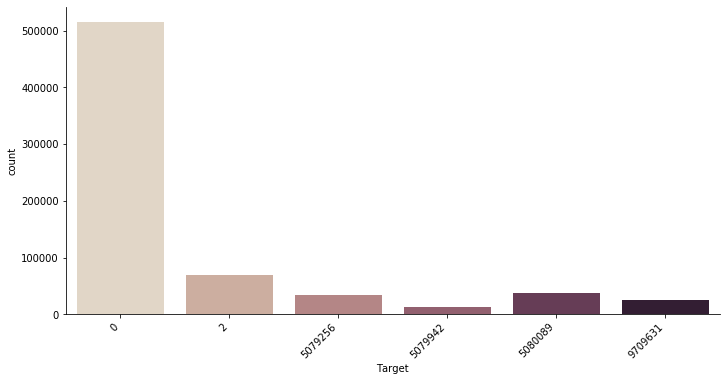

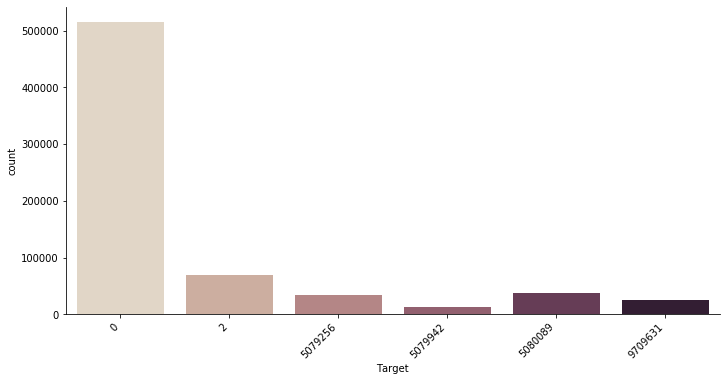

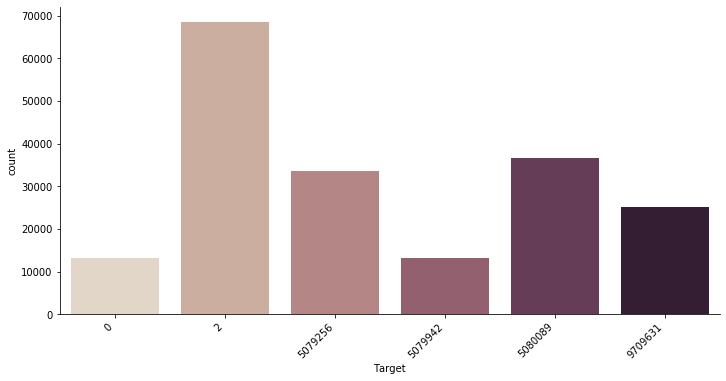

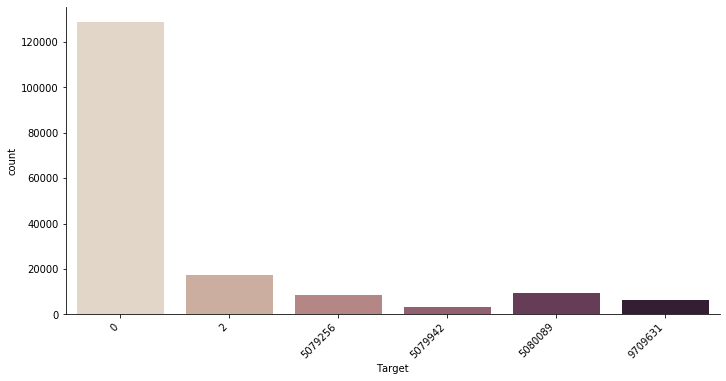

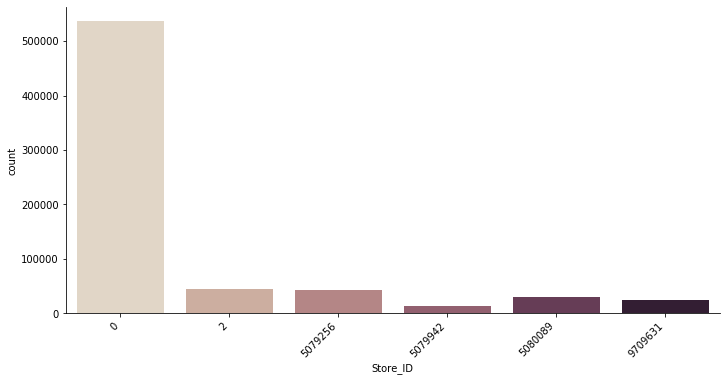

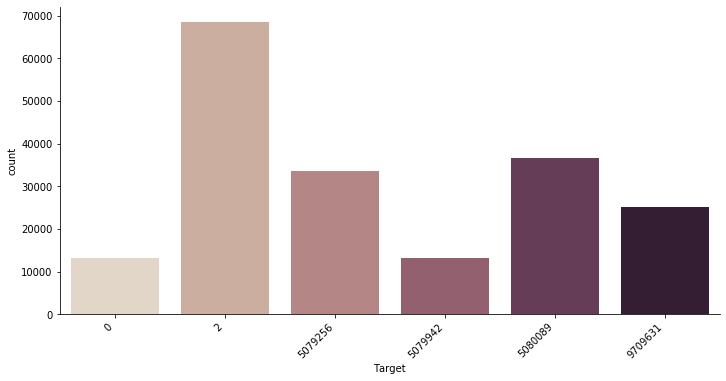

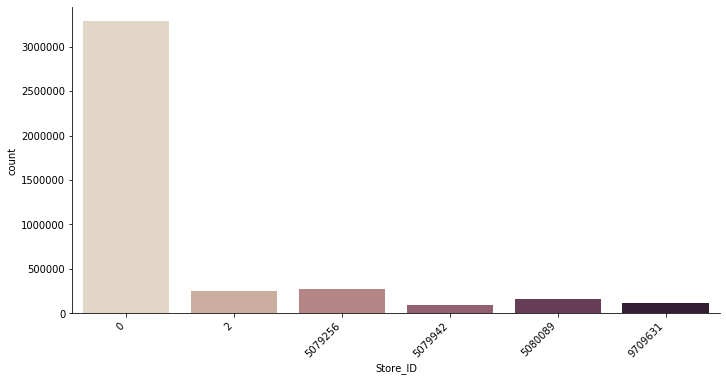

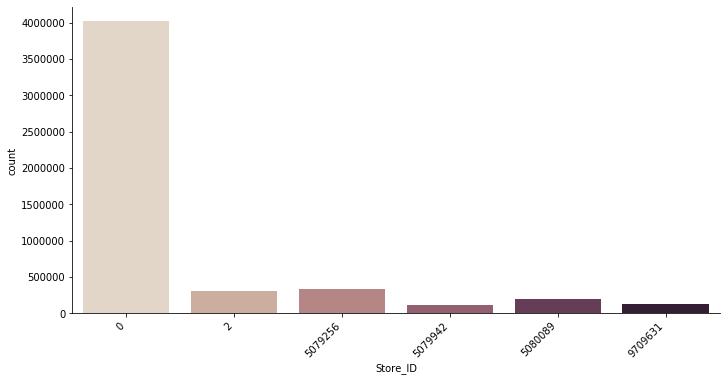

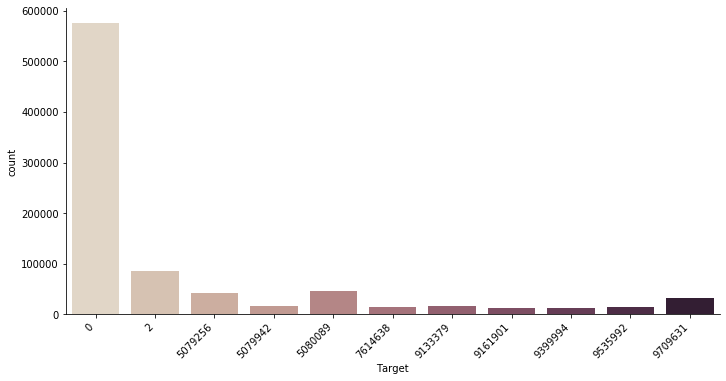

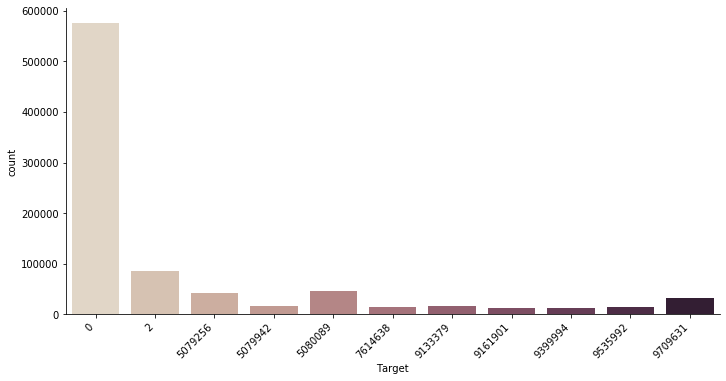

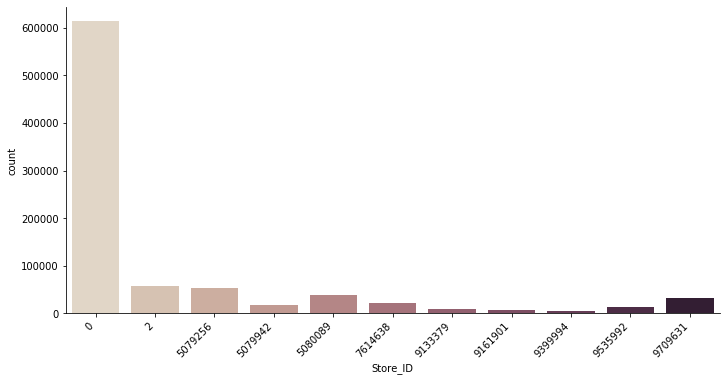

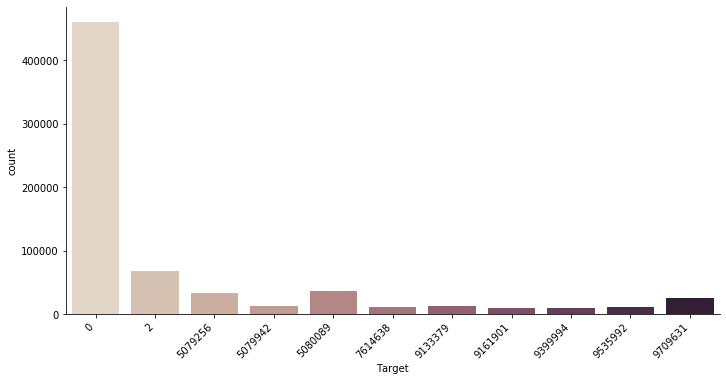

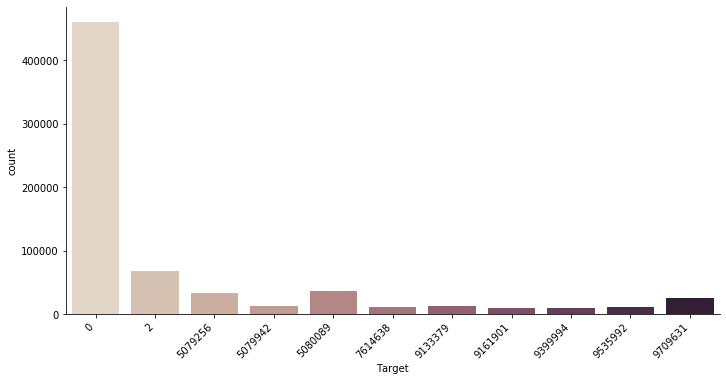

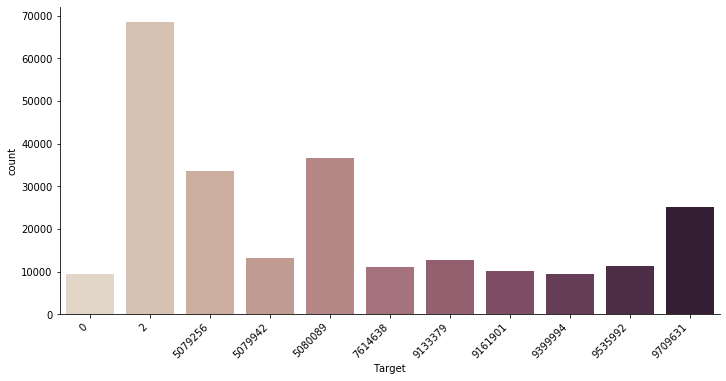

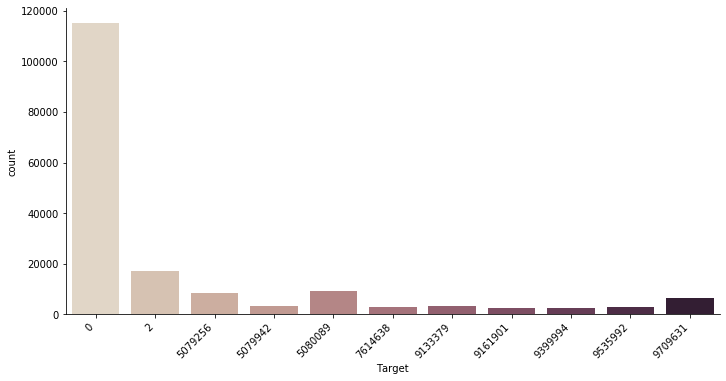

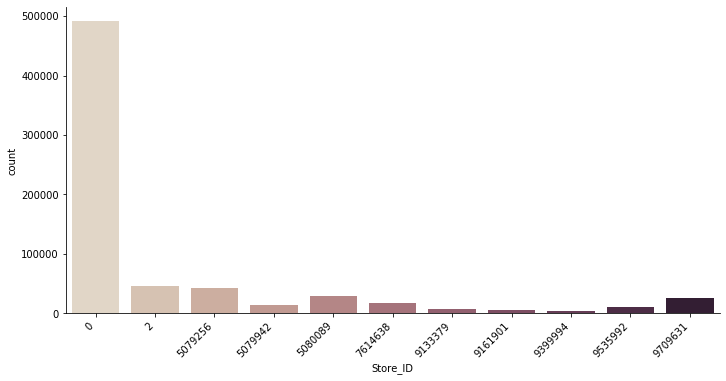

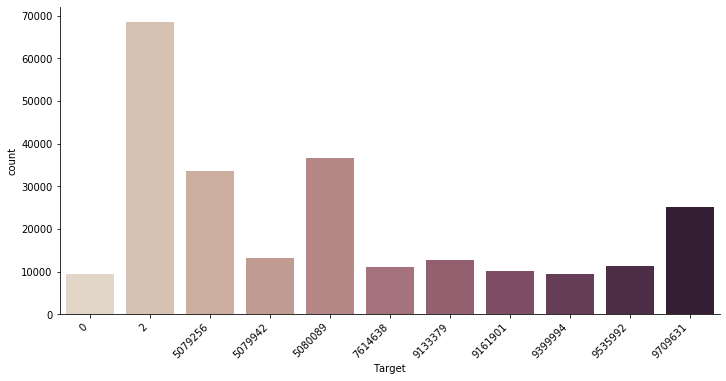

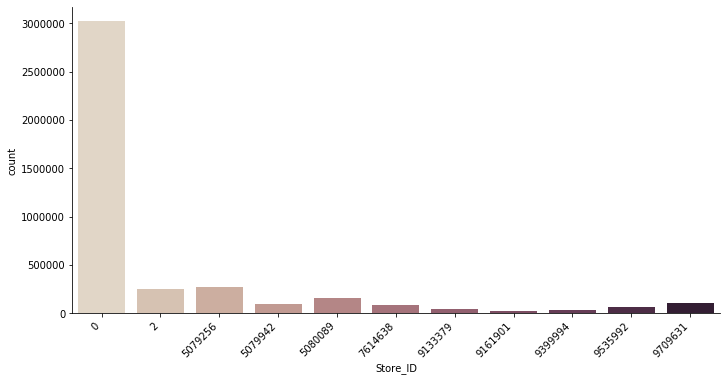

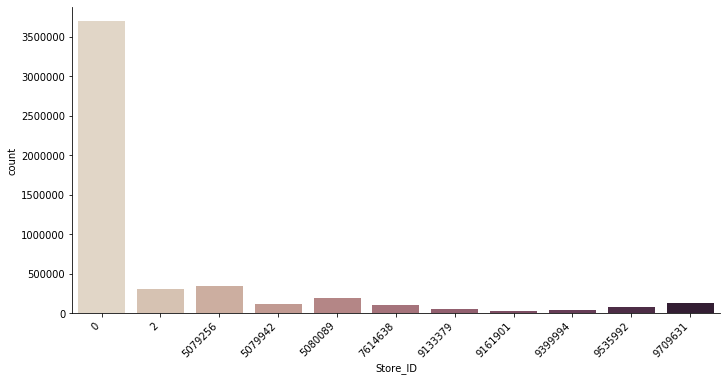

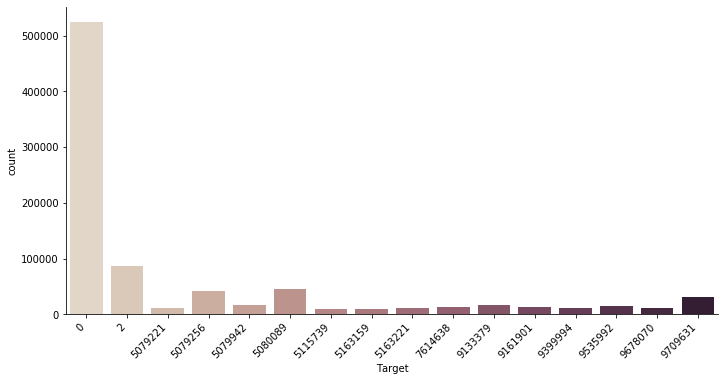

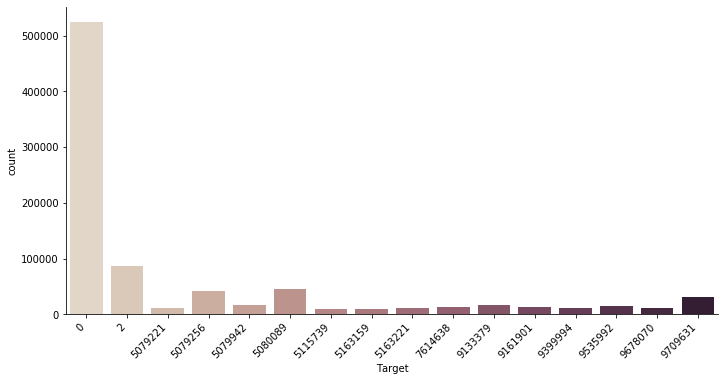

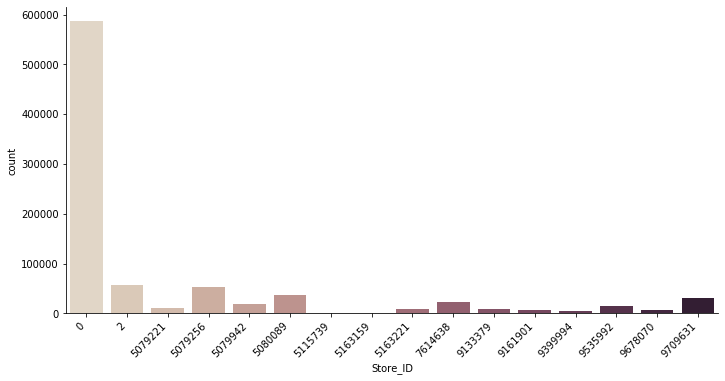

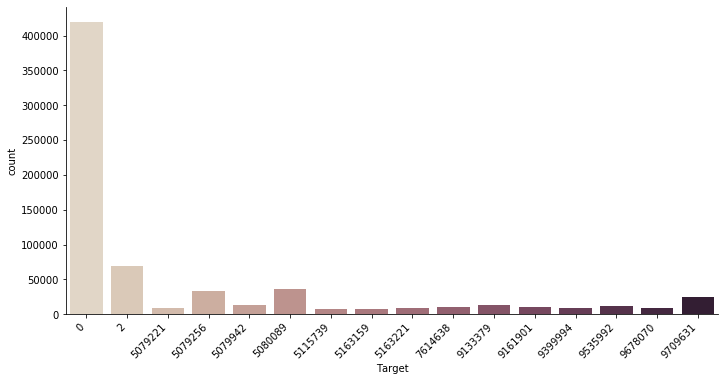

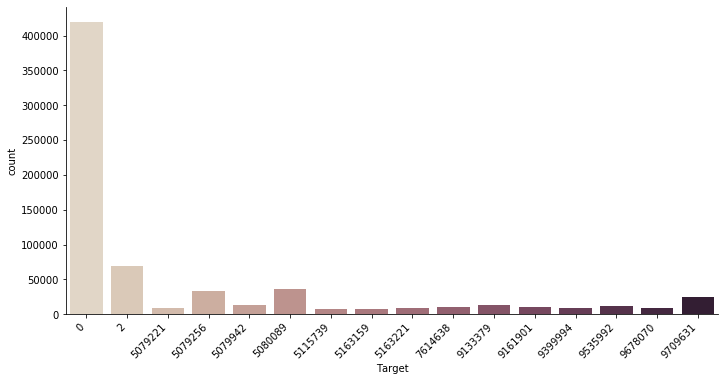

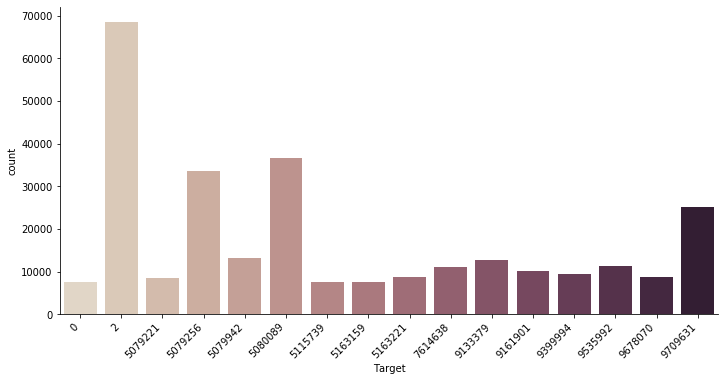

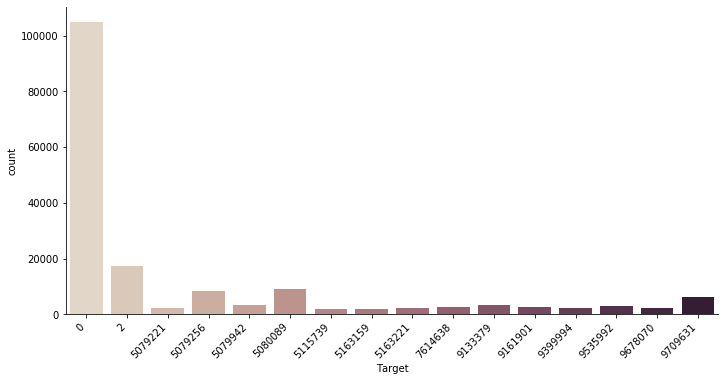

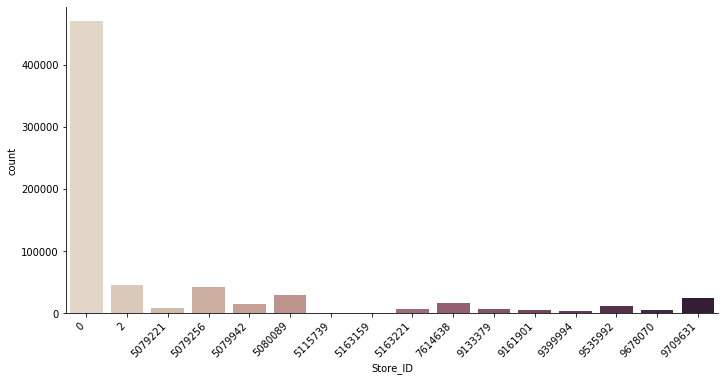

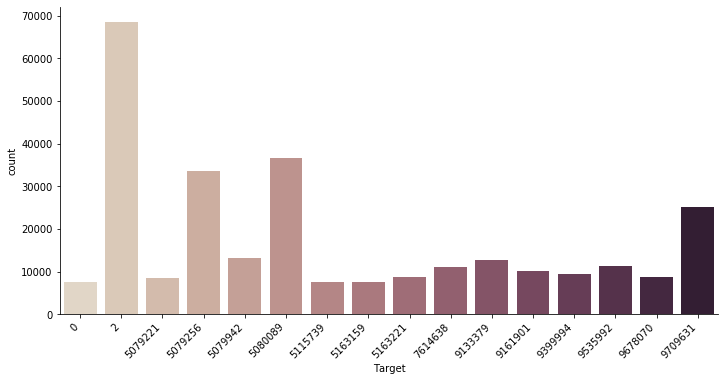

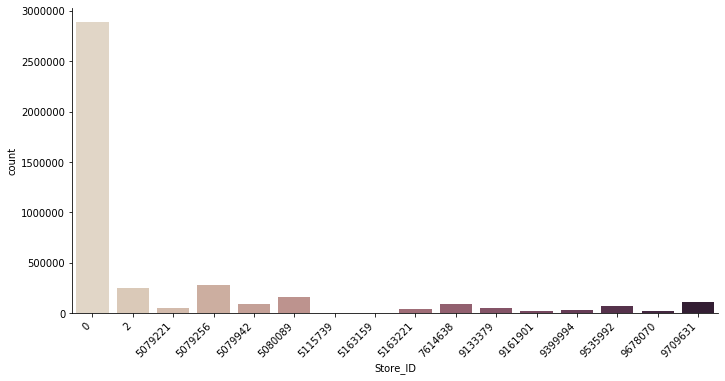

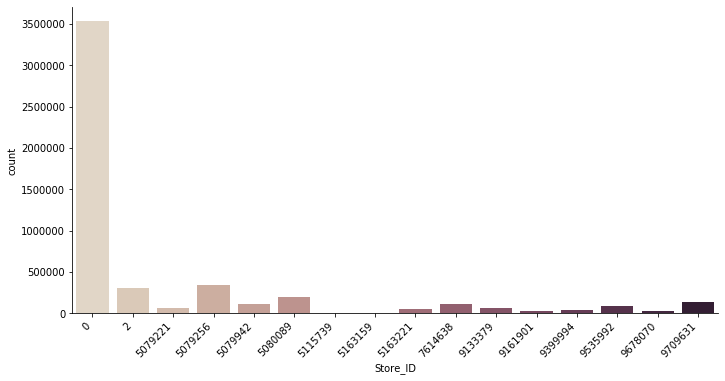

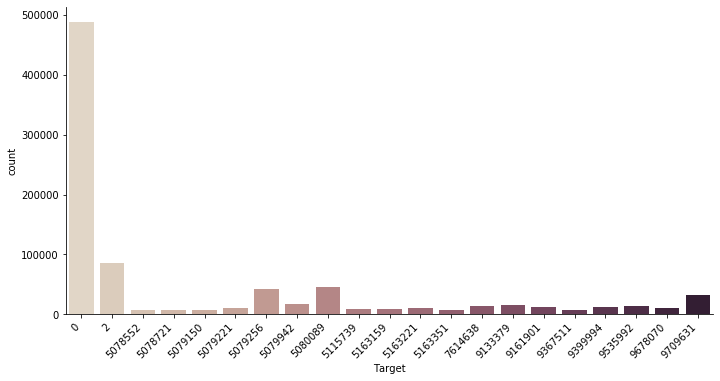

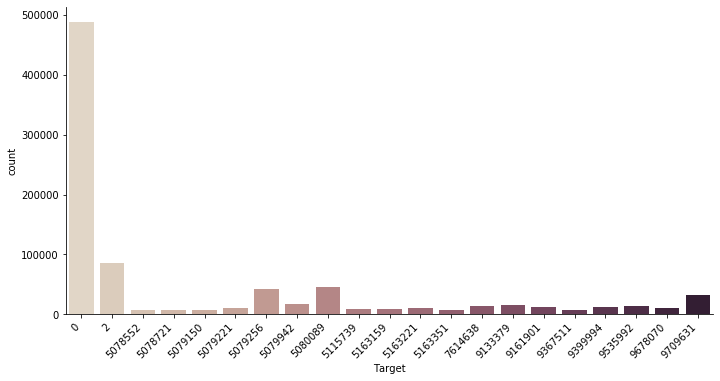

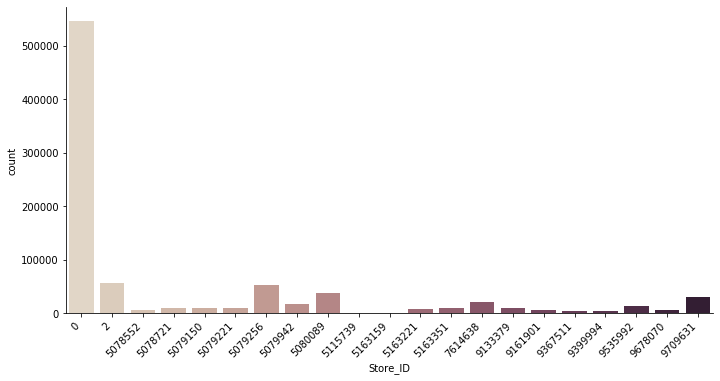

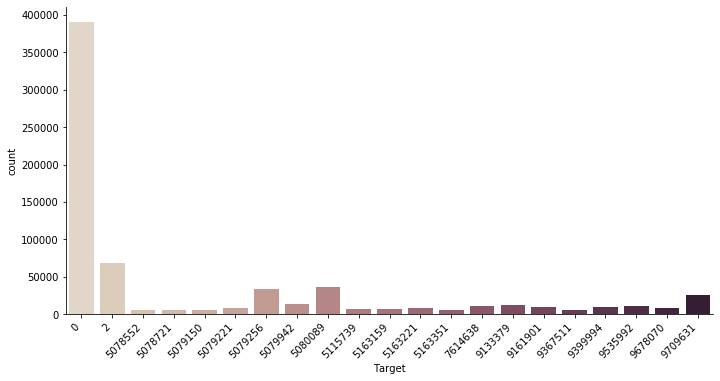

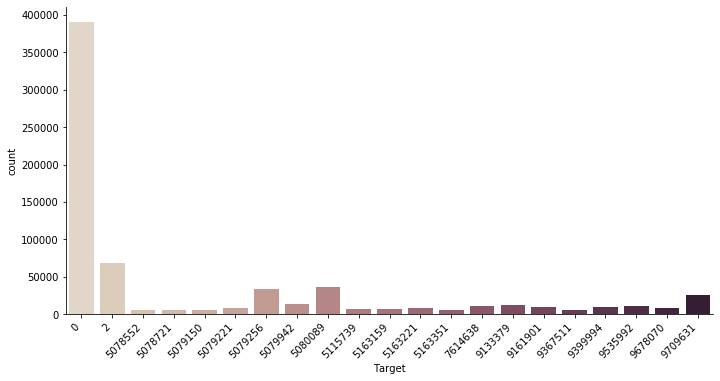

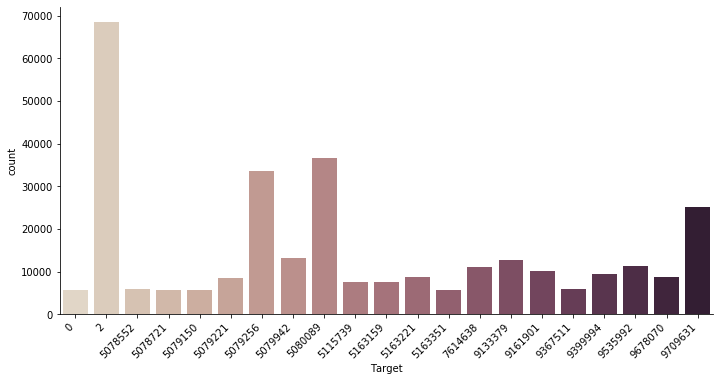

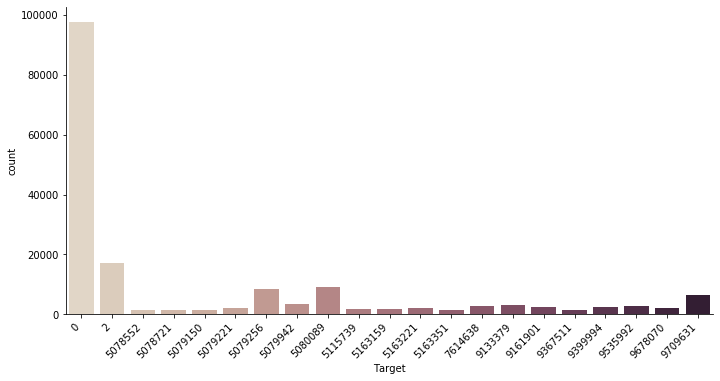

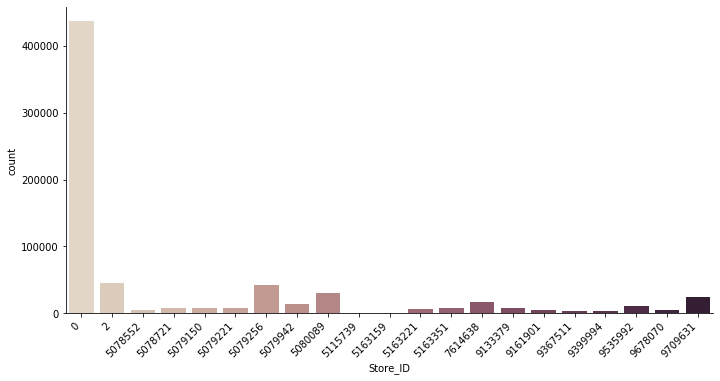

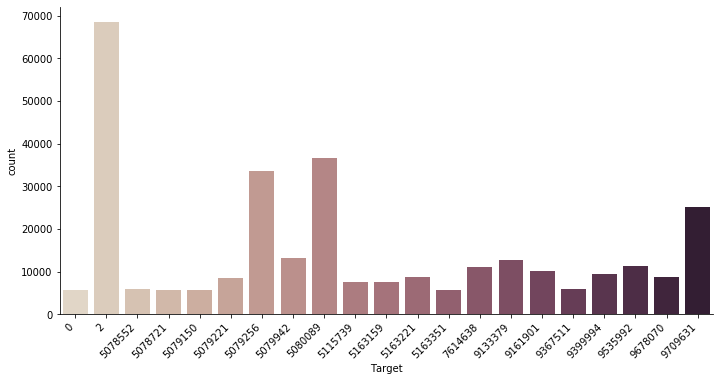

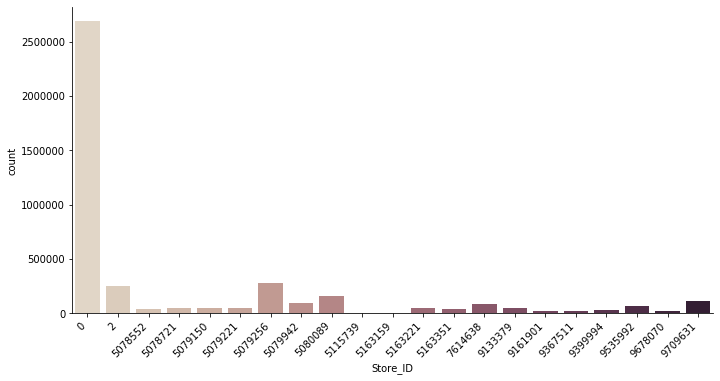

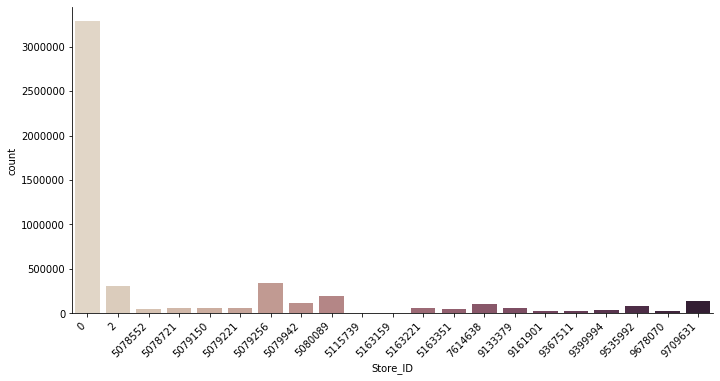

In [0]:


# new logic
class_num_to_list  = {5:five,10:ten,15:fifteen,20:twenty}

for i in class_num_to_list.keys():
  
  def conditions(x):
    if x not in class_num_to_list[i]:
      return 0
    else:
      return x 
  print(i)
  print(class_num_to_list[i])
  df_no_exit = df[df['Target']!=0]
  func = np.vectorize(conditions)
  New_Stores = func(df_no_exit["Store_ID"])
  New_Target = func(df_no_exit["Target"])
  df_no_exit['Store_ID'] = New_Stores
  df_no_exit['Target'] = New_Target
  
  ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=df_no_exit,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=df_no_exit,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=df_no_exit,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  df_no_exit_wo_seq = df_no_exit

  df_no_exit_wo_seq.sort_values(by=['DateTime','Customer_ID','Sequence_Num'])

  print("Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model")

  split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

  for train_index, test_index in split.split(df_no_exit_wo_seq, df_no_exit_wo_seq['Target']):
    strat_train_stores_wo_seq = df_no_exit_wo_seq.iloc[train_index]
    strat_test_stores_wo_seq = df_no_exit_wo_seq.iloc[test_index]

  print("The distribution of train/test split is identical but there is a huge imbalance in the classes")
  ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores_wo_seq,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')
  ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores_wo_seq,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')
  X_train_store_wo_seq = strat_train_stores_wo_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
  y_train_store_wo_seq = strat_train_stores_wo_seq[['Target']]
  X_test_store_wo_seq = strat_test_stores_wo_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
  y_test_store_wo_seq = strat_test_stores_wo_seq[['Target']]

  print("Training a Random Forest Classfier")
  rnd_clf_wo_seq = RandomForestClassifier(n_estimators=100, max_depth=15,n_jobs=-1,random_state=5,criterion='entropy')
  rnd_clf_wo_seq.fit(X_train_store_wo_seq,y_train_store_wo_seq)

  score = rnd_clf_wo_seq.score(X_train_store_wo_seq, y_train_store_wo_seq)
  score2 = rnd_clf_wo_seq.score(X_test_store_wo_seq, y_test_store_wo_seq)
  y_pred_stores = rnd_clf_wo_seq.predict(X_test_store_wo_seq)
  f1 = f1_score(y_test_store_wo_seq, y_pred_stores,average='macro')
  print("rnd_clf_wo_seq - Training set accuracy: ", '%.3f'%(score))
  print("rnd_clf_wo_seq - Test set accuracy: ", '%.3f'%(score2))
  print("rnd_clf_wo_seq - Test set F1-Score: ", '%.3f'%(f1))

  y_pred_stores_wo_seq = rnd_clf_wo_seq.predict(X_test_store_wo_seq)
  print(classification_report(y_test_store_wo_seq,y_pred_stores_wo_seq))


  print("The distribution of 'other' stores is highly skewed and during training there would be a risk off overfitting on the majority class. As a result we will perform downsampling on the training data. We have wnough number of instances for us to downsample the data. We will resample without replacement and reduce the sample of overweighted class to match one of the minority class")
    ###################################################LINE BREAKER
  #downsampling
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("#####################################        LINE BREAKER         #################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("downsampling")
  df_exit_no_seq = df_no_exit
  df_exit_no_seq.count()

  split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

  for train_index, test_index in split.split(df_exit_no_seq, df_exit_no_seq['Target']):
    strat_train_stores_no_seq = df_exit_no_seq.iloc[train_index]
    strat_test_stores_no_seq = df_exit_no_seq.iloc[test_index]

  df_majority_no_seq = strat_train_stores_no_seq[strat_train_stores_no_seq['Target']==0]
  df_minority_no_seq = strat_train_stores_no_seq[strat_train_stores_no_seq['Target']==class_num_to_list[i][-1]]  #5079942  for 5 classes, here we want the last item of the list


  df_majority_downsampled_no_seq = resample(df_majority_no_seq, 
                                 replace=False,     
                                 n_samples=len(df_minority_no_seq),   
                                 random_state=42) 

  class_num_to_list[i]

  strat_train_stores_no_seq = strat_train_stores_no_seq[strat_train_stores_no_seq['Target']!=0]
  strat_train_stores_no_seq = pd.concat([df_majority_downsampled_no_seq, strat_train_stores_no_seq])
  strat_train_stores_no_seq = shuffle(strat_train_stores_no_seq)

  ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores_no_seq,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_test_stores_no_seq,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  X_train_store_no_seq = strat_train_stores_no_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
  y_train_store_no_seq = strat_train_stores_no_seq[['Target']]
  X_test_store_no_seq = strat_test_stores_no_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
  y_test_store_no_seq = strat_test_stores_no_seq[['Target']]

  rnd_clf_no_seq = RandomForestClassifier(n_estimators=100, max_depth=15,n_jobs=-1,random_state=5,criterion='entropy')
  rnd_clf_no_seq.fit(X_train_store_no_seq,y_train_store_no_seq)

  score = rnd_clf_no_seq.score(X_train_store_no_seq, y_train_store_no_seq)
  score2 = rnd_clf_no_seq.score(X_test_store_no_seq, y_test_store_no_seq)
  y_pred_stores = rnd_clf_wo_seq.predict(X_test_store_no_seq)
  f1 = f1_score(y_test_store_no_seq, y_pred_stores,average='macro')

  print("rnd_clf_wo_seq - downsampled - Training set accuracy: ", '%.3f'%(score))
  print("rnd_clf_wo_seq - downsampled - Test set accuracy: ", '%.3f'%(score2))
  print("rnd_clf_wo_seq - downsampled - Test set F1-Score: ", '%.3f'%(f1))

  y_pred_stores_no_seq = rnd_clf_no_seq.predict(X_test_store_no_seq)
  print(classification_report(y_test_store_no_seq,y_pred_stores_no_seq))
  ###################################################LINE BREAKER
  #An additional signal using Sequence and taking into account a customer's history until that point
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("#####################################        LINE BREAKER         #################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("An additional signal using Sequence and taking into account a customer's history until that point")
  df_no_exit_w_seq = df_no_exit
  df_no_exit_w_seq.count()
  class_num_to_list[i]

  df_one_hot = pd.get_dummies(df_no_exit['Store_ID'])
  df_no_exit_w_seq= df_no_exit_w_seq.join(df_one_hot)
  column_list = ['Customer_ID','Store_ID','Dwell_Time','Day','Sequence_Num','Category_ID','Month',0]
  column_list.extend(class_num_to_list[i])
  column_list.append('Target')
  print(column_list)
  df_no_exit_w_seq =df_no_exit_w_seq[column_list]

#  BEFORE:  df_no_exit_w_seq =df_no_exit_w_seq[['Customer_ID','Store_ID','Dwell_Time','Day','Sequence_Num','Category_ID','Month', 0, 2, 5079256, 5079942 ,5080089,9709631,'Target']]

  df_no_exit_w_seq.sort_values(by=['Day','Month','Customer_ID','Sequence_Num'])

  list_other = list(range(1))
  list_other.extend(class_num_to_list[i])

  df_sequence = df_no_exit_w_seq.groupby(by=['Day','Month','Customer_ID'])[list_other].cumsum(axis=0) # Tracking the sequence using cumalative sum
  df_no_exit_w_seq.drop(columns=list_other,axis=0,inplace=True)
  df_no_exit_w_seq = df_no_exit_w_seq.merge(df_sequence,how='inner',left_index=True,right_index=True)
  df_no_exit_w_seq
  #why all went to 0

  print("Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model")
  split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

  for train_index, test_index in split.split(df_no_exit_w_seq, df_no_exit_w_seq['Target']):
    strat_train_stores = df_no_exit_w_seq.iloc[train_index]
    strat_test_stores = df_no_exit_w_seq.iloc[test_index]

  ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=strat_train_stores,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  df_majority = strat_train_stores[strat_train_stores['Target']==0]
  df_minority = strat_train_stores[strat_train_stores['Target']==class_num_to_list[i][-1]]


  df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 


  strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
  strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
  strat_train_stores = shuffle(strat_train_stores)

  ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  #train & test features
  train_test_features = ['Day','Month','Dwell_Time',0]
  train_test_features.extend(class_num_to_list[i])
  print(train_test_features)

  
  X_train_store = strat_train_stores[train_test_features]
  y_train_store = strat_train_stores[['Target']]
  X_test_store = strat_test_stores[train_test_features]
  y_test_store = strat_test_stores[['Target']]

  rnd_clf = RandomForestClassifier(n_estimators=100, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
  rnd_clf.fit(X_train_store,y_train_store)

  y_pred_stores = rnd_clf.predict(X_test_store)

  f1 = f1_score(y_test_store, y_pred_stores,average='macro')
  score = rnd_clf.score(X_train_store, y_train_store)
  score2 = rnd_clf.score(X_test_store, y_test_store)
  print("df_no_exit_w_seq  -  Training set accuracy: ", '%.3f'%(score))
  print("df_no_exit_w_seq  -  Test set accuracy: ", '%.3f'%(score2))
  print("df_no_exit_w_seq  -  Test set F1-Score: ", '%.3f'%(f1))


  print(classification_report(y_test_store,y_pred_stores))

  cols = X_train_store.columns
  feature_importance_all = rnd_clf.feature_importances_
  feature_importance = {}
  for j in  range(len(cols)):
    feature_importance[cols[j]] = feature_importance_all[j]

  feature_import =  pd.DataFrame.from_dict(feature_importance, 
                                         orient = 'index',columns=['Importance'])
  feature_import.sort_values(by='Importance',ascending=False)

###################################################LINE BREAKER
  #One more added signal by tracking the dwell time as the customer moves from one store to the nex
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("#####################################        LINE BREAKER         #################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("One more added signal by tracking the dwell time as the customer moves from one store to the nex")


  df_extra_dwell = df_no_exit.pivot_table(values=['Dwell_Time'],index=['DateTime','Customer_ID','Sequence_Num'],columns=['Store_ID']).fillna(0).sort_values(by=['Customer_ID'])
  df_extra_dwell.reset_index(inplace = True)

  df_no_exit_dwell = df_no_exit_w_seq.merge(df_extra_dwell,how='inner', on='Customer_ID')
  split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

  for train_index, test_index in split.split(df_no_exit_dwell, df_no_exit_dwell['Target']):
    strat_train_stores = df_no_exit_dwell.iloc[train_index]
    strat_test_stores = df_no_exit_dwell.iloc[test_index]

  ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=strat_train_stores,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  df_majority = strat_train_stores[strat_train_stores['Target']==0]
  df_minority = strat_train_stores[strat_train_stores['Target']==class_num_to_list[i][-1]]

  df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 


  strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
  strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
  strat_train_stores = shuffle(strat_train_stores)

  train_test_features = ['Day','Category_ID','Month']
  list_other = list(range(1))
  list_other.extend(class_num_to_list[i])

  train_test_features.extend(list_other)
#for i in len(class_num_to_list[20]):
#  tup_temp = ()
  dwell_zzz = ['Dwell_Time']*len(list_other)
  dwell_cols = list(zip(dwell_zzz,list_other))
  train_test_features.extend(dwell_cols)
  train_test_features


  X_train_store = strat_train_stores[train_test_features]
  y_train_store = strat_train_stores[['Target']]
  X_test_store = strat_test_stores[train_test_features]
  y_test_store = strat_test_stores[['Target']]

# original    X_train_store = strat_train_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
# original    y_train_store = strat_train_stores[['Target']]
# original    X_test_store = strat_test_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
# original    y_test_store = strat_test_stores[['Target']]
  print(train_test_features)

  rnd_clf = RandomForestClassifier(n_estimators=100, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
  rnd_clf.fit(X_train_store,y_train_store)

  y_pred_stores = rnd_clf.predict(X_test_store)

  f1 = f1_score(y_test_store, y_pred_stores,average='macro')
  score = rnd_clf.score(X_train_store, y_train_store)
  score2 = rnd_clf.score(X_test_store, y_test_store)

  print("df_extra_dwell_noexit - Training set accuracy: ", '%.3f'%(score))
  print("df_extra_dwell_noexit - Test set accuracy: ", '%.3f'%(score2))
  print("df_extra_dwell_noexit - Test set F1-Score: ", '%.3f'%(f1))

  print(classification_report(y_test_store,y_pred_stores))

###################################################LINE BREAKER
  #Removing all customers who only go to one store and we do not have a history available
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("#####################################        LINE BREAKER         #################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("###################################################################################################")
  print("Removing all customers who only go to one store and we do not have a history available")


  df_two_or_more = df_no_exit_dwell[df_no_exit_dwell.duplicated('Customer_ID', keep= False)]

  split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

  for train_index, test_index in split.split(df_two_or_more, df_two_or_more['Target']):
    strat_train_stores = df_two_or_more.iloc[train_index]
    strat_test_stores = df_two_or_more.iloc[test_index]

  ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=df_two_or_more,height=5, aspect=2)
  ax.set_xticklabels( rotation=45, horizontalalignment='right')

  df_majority = strat_train_stores[strat_train_stores['Target']==0]
  df_minority = strat_train_stores[strat_train_stores['Target']==class_num_to_list[i][-1]]


  df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 


  strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
  strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
  strat_train_stores = shuffle(strat_train_stores)

  train_test_features = ['Day','Category_ID','Month']
  list_other = list(range(1))
  list_other.extend(class_num_to_list[i])

  train_test_features.extend(list_other)
#for i in len(class_num_to_list[20]):
#  tup_temp = ()
  dwell_zzz = ['Dwell_Time']*len(list_other)
  dwell_cols = list(zip(dwell_zzz,list_other))
  train_test_features.extend(dwell_cols)
  train_test_features

  X_train_store = strat_train_stores[train_test_features]
  y_train_store = strat_train_stores[['Target']]
  X_test_store = strat_test_stores[train_test_features]
  y_test_store = strat_test_stores[['Target']]
#X_train_store = strat_train_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
#y_train_store = strat_train_stores[['Target']]
#X_test_store = strat_test_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
#y_test_store = strat_test_stores[['Target']]


  rnd_clf = RandomForestClassifier(n_estimators=100, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
  rnd_clf.fit(X_train_store,y_train_store)
  y_pred_stores = rnd_clf.predict(X_test_store)
  f1 = f1_score(y_test_store, y_pred_stores,average='macro')
  score = rnd_clf.score(X_train_store, y_train_store)
  score2 = rnd_clf.score(X_test_store, y_test_store)

  print("df_two_or_more - Training set accuracy: ", '%.3f'%(score))
  print("df_two_or_more - Test set accuracy: ", '%.3f'%(score2))
  print("df_two_or_more - Test set F1-Score: ", '%.3f'%(f1))
  print(classification_report(y_test_store,y_pred_stores))

  df_extra_dwell_total = df_no_exit.pivot_table(values=['Dwell_Time'],index=['Customer_ID'],columns=['Store_ID']).fillna(0).sort_values(by=['Customer_ID'])
  df_extra_dwell_total.reset_index(inplace = True)

  df_no_exit_dwell_total = df_no_exit_dwell.merge(df_extra_dwell_total,how='left', on='Customer_ID')

  split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

  for train_index, test_index in split.split(df_no_exit_dwell_total, df_no_exit_dwell_total['Target']):
    strat_train_stores = df_no_exit_dwell_total.iloc[train_index]
    strat_test_stores = df_no_exit_dwell_total.iloc[test_index]

  df_majority = strat_train_stores[strat_train_stores['Target']==0]
  df_minority = strat_train_stores[strat_train_stores['Target']==class_num_to_list[i][-1]]


  df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 

  strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
  strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
  strat_train_stores = shuffle(strat_train_stores)

  list_column_all = strat_train_stores.columns.tolist()

  list_column_all

  list_column_all = strat_train_stores.columns.tolist()
  list_remove = ['Customer_ID','Store_ID','Dwell_Time_x','Sequence_Num','Target',('DateTime', ''),('Sequence_Num', '')]
  for j in list_remove:
    pop_num = list_column_all.index(j)
    list_column_all.pop(pop_num)
  list_column_all

  X_train_store = strat_train_stores[list_column_all]
  y_train_store = strat_train_stores[['Target']]
  X_test_store = strat_test_stores[list_column_all]
  y_test_store = strat_test_stores[['Target']]
#X_train_store = strat_train_stores[['Day','Category_ID','Month', 0,2, 5079256, 5079942, 5080089, 9709631,"('Dwell_Time', 0)_x", "('Dwell_Time', 2)_x","('Dwell_Time', 5079256)_x", "('Dwell_Time', 5079942)_x","('Dwell_Time', 5080089)_x", "('Dwell_Time', 9709631)_x",('Dwell_Time_y', 0),('Dwell_Time_y', 2),('Dwell_Time_y', 5079256), ('Dwell_Time_y', 5079942),('Dwell_Time_y', 5080089),   ('Dwell_Time_y', 9709631)]]
#y_train_store = strat_train_stores[['Target']]
#X_test_store = strat_test_stores[['Day','Category_ID','Month', 0,2, 5079256, 5079942, 5080089, 9709631,"('Dwell_Time', 0)_x", "('Dwell_Time', 2)_x","('Dwell_Time', 5079256)_x", "('Dwell_Time', 5079942)_x","('Dwell_Time', 5080089)_x", "('Dwell_Time', 9709631)_x",('Dwell_Time_y', 0),('Dwell_Time_y', 2),('Dwell_Time_y', 5079256), ('Dwell_Time_y', 5079942),('Dwell_Time_y', 5080089),   ('Dwell_Time_y', 9709631)]]
#y_test_store = strat_test_stores[['Target']]

  rnd_clf = RandomForestClassifier(n_estimators=100, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
  rnd_clf.fit(X_train_store,y_train_store)

  y_pred_stores = rnd_clf.predict(X_test_store)

  f1 = f1_score(y_test_store, y_pred_stores,average='macro')
  print("df_extra_dwell_total - Test set F1-Score: ", '%.3f'%(f1))

  f2 = recall_score(y_test_store, y_pred_stores, average = 'weighted')
  print("df_extra_dwell_total - Test set Recall: ", '%.3f'%(f2))

  score = rnd_clf.score(X_train_store, y_train_store)
  score2 = rnd_clf.score(X_test_store, y_test_store)

  print("df_extra_dwell_total - Training set accuracy: ", '%.3f'%(score))
  print("df_extra_dwell_total - Test set accuracy: ", '%.3f'%(score2))

  print(classification_report(y_test_store,y_pred_stores))

  cols = X_train_store.columns
  feature_importance_all = rnd_clf.feature_importances_
  feature_importance = {}
  for j in  range(len(cols)):
    feature_importance[cols[j]] = feature_importance_all[j]

  feature_import =  pd.DataFrame.from_dict(feature_importance, 
                                         orient = 'index',columns=['Importance'])
  feature_import.sort_values(by='Importance',ascending=False)








































